<a href="https://colab.research.google.com/github/ml2-picme/PicMe/blob/master/Image%20Download%20and%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Helper Functions

In [0]:
from keras.preprocessing.image import load_img, img_to_array
import urllib.request

def downloadFileFromUrl(URL, localPath):
  print("Lade ", URL, " nach ", localPath + " herunter")
  with urllib.request.urlopen(URL) as url:
    with open(localPath, 'wb') as f:
      f.write(url.read())
  load_img(localPath)

In [0]:
def getFileNameFromPath(path):
  filename = path.split("/")[len(path.split("/")) - 1]
  return filename

In [0]:
import os

def createLocalDirectory(dir):
  
  print("Erstelle lokales Verzeichnis:", dir, end='\t')
  
  try:  
    os.makedirs(dir)

  except OSError:  
    print (" - Failed")
  else:
    print(" - OK")

In [0]:
import os
import shutil

def deleteLocalFiles(dir):
  try:
    print("Delete local files", end='')  
    shutil.rmtree(dir) 
    print(" - OK")
  except OSError:
    print(" - Failed")

In [0]:
import os

def findFilesInPath(dir, extensions):

  files = []
  
  # r=root, d=directories, f = files
  for r, d, f in os.walk(dir):
    for file in f:
      for extension in extensions:
        if file.lower().endswith(extension.lower()):
            files.append(os.path.join(r, file))
            break
            
  return files

In [0]:
from PIL import Image
import numpy as np

def prepareImagesForClassification(files, sizeX, sizeY):
  images = []
  
  for file in files:
    try:
      image = Image.open(file)
      image = image.resize((sizeX, sizeY), Image.LANCZOS)
      image = image.convert("RGB")
      
      image = np.asarray(image)
      images.append(image)
    except OSError:
      pass
  
  images = np.asarray(images)
  return images

In [0]:
def classifyImages(preparedImages, preprocess_input_function, decode_predictions_function, model):
  
  # preprocess the images to fit to the model
  images_preprocessed = preprocess_input_function(preparedImages)
  
  # use the model to classifi the images
  images_pred = model.predict(images_preprocessed, verbose=1)
  
  pred_results = decode_predictions_function(images_pred)
  
  return pred_results

In [0]:
import matplotlib.pyplot as plt

def printClassificationResults(images, predictedClasses):
  
  for i in range(len(images)):
    plt.figure()
    plt.imshow(images[i])
    plt.title(predictedClasses[i])
    plt.axis('off')
    plt.show()
    plt.clf()

In [0]:
def compareResults(fileNames, resulsList, modelList, threshold):
  
  for i in range(len(fileNames)):
    print("Comparing the Results for File: " + fileNames[i])
    
    for j in range(5):
      for k in range(len(modelList)):
        resultToPrint = resultsList[k][i][j]
        
        # Setze 5% als Threshold
        if(resultToPrint is not None and resultToPrint[2] > threshold):
          print(" > ", (j+1), ". Platz @ ", modelList[k], " : ", resultsList[k][i][j])
        else:
          print(" > ", (j+1), ". Platz @ ", modelList[k], " : ", "--- Threshold-Filter ---")
      
      print("=================================================================")
      
    print("")

In [0]:
def generateCsvForModelComparison(fileNames, resulsList, modelList):
  allModelCSVs = []
  
  for k in range(len(modelList)):
    modelCSV = modelList[k]
    
    for i in range(len(fileNames)):
      modelCSV += ";" + getFileNameFromPath(fileNames[i])
      
    modelCSV += "\n"
    
    for j in range(5):
      modelCSV += str(j+1) + ".Platz"
      
      for i in range(len(fileNames)):
        modelCSV += ";" + str(resultsList[k][i][j][1])
        
      modelCSV += "\n"
      
    allModelCSVs.append(modelCSV)
        
  return allModelCSVs

In [83]:
# MySQL Part -> Writing Image Classification Results to DB
!pip install mysql-connector-python-rf

import mysql.connector

def storeResultsToDB(fileNames, resulsList, modelList):
  
  cnx = mysql.connector.connect(user='ml2', password='ml2@hsOg#2019!',
                              host='192.52.33.218',
                              database='ml2')
  cursor = cnx.cursor()
  add_result = ("insert into results (local_path, model, prediction_class, prediction_probability) values (%s, %s, %s, %s)")
  
  for k in range(len(modelList)):
    
    print("==== other model =====")
    
    for i in range(len(fileNames)):
      
      print("==== other file =====")
      
      for j in range(5):
        
        fileName = fileNames[i]
        modelName = modelList[k]
        predictedClass = resultsList[k][i][j][1]
        predictedPropability = resultsList[k][i][j][2]
  
        #print(fileName)
        #print(modelName)
        #print(predictedClass)
        #print(predictedPropability)
        #print("==============")
        
        data_result = (fileName, modelName, predictedClass, float(predictedPropability))
        cursor.execute(add_result, data_result)
        result_id = cursor.lastrowid
        
        print(result_id, " | ", fileName, " | ", modelName, " | ", predictedClass, " | ", predictedPropability)
       
        cnx.commit()
        
  cursor.close()
  cnx.close()

In [108]:
!pip install mysql-connector-python-rf

import mysql.connector
import matplotlib.pyplot as plt

def querySearchWord(searchWord):
  cnx = mysql.connector.connect(user='ml2', password='ml2@hsOg#2019!',
                              host='192.52.33.218',
                              database='ml2')
  cursor = cnx.cursor()
  query = ("select distinct local_path, prediction_class from results where prediction_class = %s")
  
  cursor.execute(query, (searchWord,))
  
  print("Found following files for your search word \"" + searchWord + "\":")
  
  for (local_path, prediction_class) in cursor:
    foundFiles = [open(local_path, 'rb')]
    preparedImage224x224 = prepareImagesForClassification(foundFiles, 224, 224)[0]

    plt.figure()
    plt.imshow(preparedImage224x224)
    plt.title("{}".format(local_path))
    plt.axis('off')
    plt.show()
    plt.clf()



  cursor.close()
  cnx.close()  

Found following files for your search word "bucket":


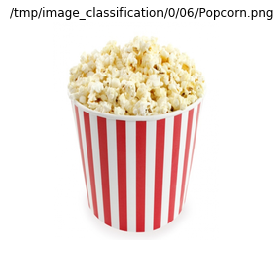

<Figure size 432x288 with 0 Axes>

In [110]:
querySearchWord("bucket")

## Logic

In [0]:
# Parameters
path = "/tmp/image_classification"
hashrange = 20

In [86]:
# Preparation: Delete local files
deleteLocalFiles(path)

Delete local files - OK


In [87]:
# Preparation: Create local directory structure
for i in range(hashrange):
  if(i % 10 == 0):
    parentPath = path + "/" + str((int)(i/10))
    createLocalDirectory(parentPath)
  normalizedI = '%02d' % i  # Normalization, pad zeroes
  filePath = parentPath + "/" + normalizedI
  createLocalDirectory(filePath)

Erstelle lokales Verzeichnis: /tmp/image_classification/0	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/0/00	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/0/01	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/0/02	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/0/03	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/0/04	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/0/05	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/0/06	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/0/07	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/0/08	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/0/09	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/1	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/1/10	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/1/11	 - OK
Erstelle lokales Verzeichnis: /tmp/image_classification/1/12	 - OK
E

In [88]:
from urllib.request import urlopen

data = urlopen("https://raw.githubusercontent.com/ml2-picme/PicMe/master/input/images_subset.txt")
for line in data:
  if not line.startswith(b'#'):  # Ignore Lines that begin with a comment (#)
    line = line.decode("utf-8").split("\n")[0]  # Normalization
    url = line.split(";")[0]
    label = line.split(";")[1]
    
    filename = getFileNameFromPath(url)

    hashvalue = abs(hash(filename)) % hashrange
    parent_dir = (int)(hashvalue / 10)
    hashvalue = '%02d' % hashvalue  # Normalization, pad zeroes
    
    filetype = filename.split(".")[len(filename.split(".")) - 1]
    newFilename = label + "." + filetype
    #print(newFilename)

    print(url, " -> ", hashvalue, " -> ", label, " -> ", parent_dir, " -> ", filename)

    localPath = path + "/" + str(parent_dir) + "/" + hashvalue + "/" + newFilename

    downloadFileFromUrl(url, localPath)

https://www.tierpark-sababurg.de/fileadmin/_processed_/7/d/csm__MG_9788_852e2bbcb9.jpg  ->  00  ->  Bird  ->  0  ->  csm__MG_9788_852e2bbcb9.jpg
Lade  https://www.tierpark-sababurg.de/fileadmin/_processed_/7/d/csm__MG_9788_852e2bbcb9.jpg  nach  /tmp/image_classification/0/00/Bird.jpg herunter
https://www.genussvoll-dampfen.de/images/product_images/original_images/popcorn.png  ->  06  ->  Popcorn  ->  0  ->  popcorn.png
Lade  https://www.genussvoll-dampfen.de/images/product_images/original_images/popcorn.png  nach  /tmp/image_classification/0/06/Popcorn.png herunter
https://updated.de/media/cache/detailspage/cms/2018/02/maus-kaputt-tastatur-steuern.jpg  ->  11  ->  Keyboard  ->  1  ->  maus-kaputt-tastatur-steuern.jpg
Lade  https://updated.de/media/cache/detailspage/cms/2018/02/maus-kaputt-tastatur-steuern.jpg  nach  /tmp/image_classification/1/11/Keyboard.jpg herunter


In [89]:
extensionsToCheck = [".jpg", ".png", ".bmp"]
foundFiles = findFilesInPath(path, extensionsToCheck)

for foundFile in foundFiles:
  print(foundFile)

preparedImages224x224 = prepareImagesForClassification(foundFiles, 224, 224)
preparedImages299x299 = prepareImagesForClassification(foundFiles, 299, 299)

/tmp/image_classification/0/00/Bird.jpg
/tmp/image_classification/0/06/Popcorn.png
/tmp/image_classification/1/11/Keyboard.jpg
3
3


In [90]:
from keras.applications import *

# Achtung: Hier werden Funktionen übergeben: 
# 1) preprocess_input Funktion
# 2) decode_predictions Funktion
# => Dies sorgt dafür, dass die gesamte Klassifizierung ausgelagert und dynamisch aufgerufen werden kann!

predictedClassesVGG16 = classifyImages(preparedImages224x224, vgg16.preprocess_input, vgg16.decode_predictions, vgg16.VGG16(input_shape=(224, 224, 3)))
predictedClassesVGG19 = classifyImages(preparedImages224x224, vgg19.preprocess_input, vgg19.decode_predictions, vgg19.VGG19(input_shape=(224, 224, 3)))
predictedClassesMobileNetV2 = classifyImages(preparedImages224x224, mobilenet_v2.preprocess_input, mobilenet_v2.decode_predictions, mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3)))
predictedClassesResNet50 = classifyImages(preparedImages224x224, resnet50.preprocess_input, resnet50.decode_predictions, resnet50.ResNet50(input_shape=(224, 224, 3)))
predictedClassesDenseNet201 = classifyImages(preparedImages224x224, densenet.preprocess_input, densenet.decode_predictions, densenet.DenseNet201(input_shape=(224, 224, 3)))
predictedClassesInceptionV3 = classifyImages(preparedImages299x299, inception_v3.preprocess_input, inception_v3.decode_predictions, inception_v3.InceptionV3(input_shape=(299, 299, 3)))
predictedClassesXception = classifyImages(preparedImages299x299, xception.preprocess_input, xception.decode_predictions, xception.Xception(input_shape=(299, 299, 3)))
predictedClassesInceptionResNet = classifyImages(preparedImages299x299, inception_resnet_v2.preprocess_input, inception_resnet_v2.decode_predictions,inception_resnet_v2.InceptionResNetV2(input_shape=(299, 299, 3)))

Instructions for updating:
Colocations handled automatically by placer.
3/3 [==============================] - 12s 4s/step


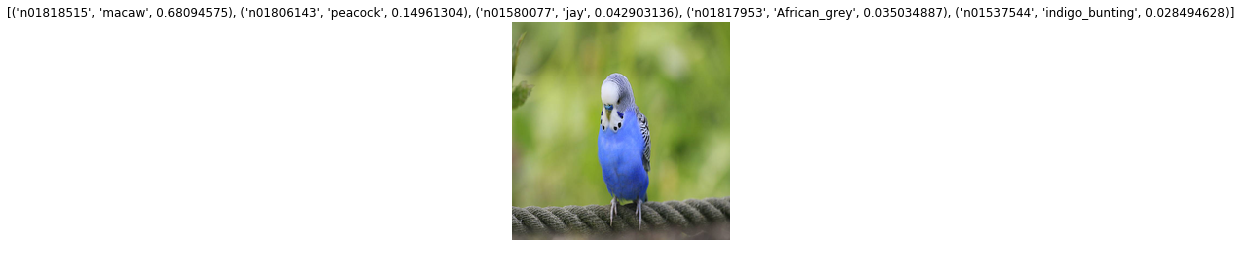

<Figure size 432x288 with 0 Axes>

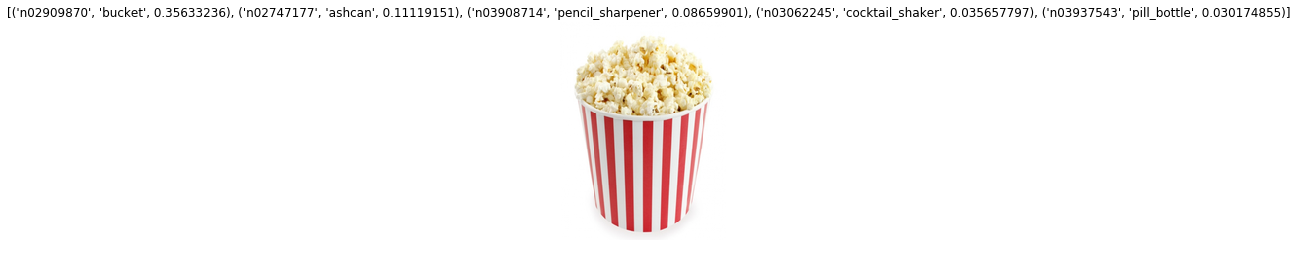

<Figure size 432x288 with 0 Axes>

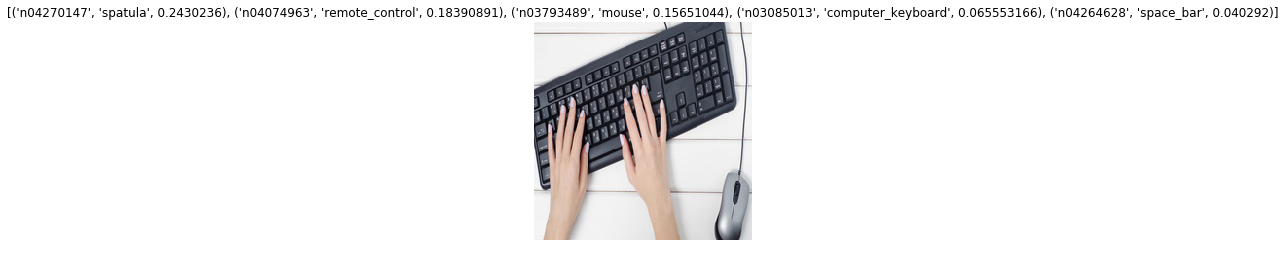

<Figure size 432x288 with 0 Axes>

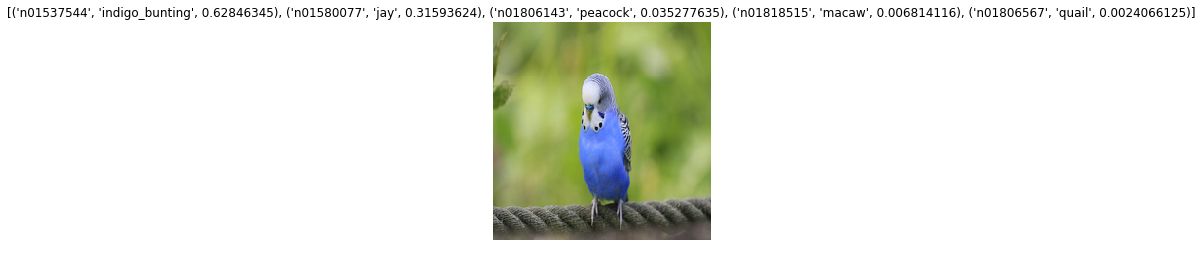

<Figure size 432x288 with 0 Axes>

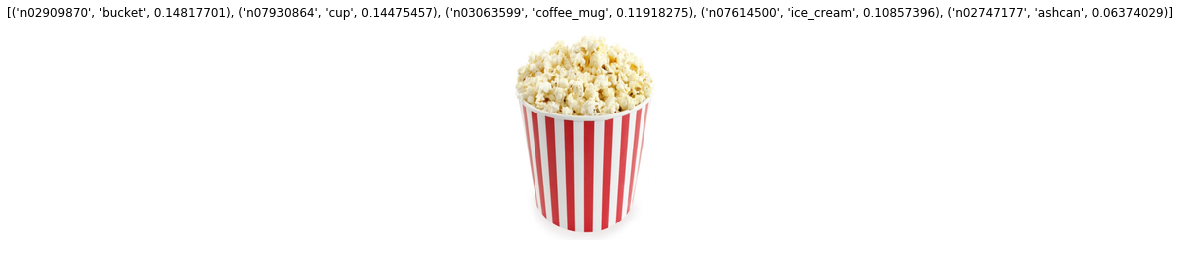

<Figure size 432x288 with 0 Axes>

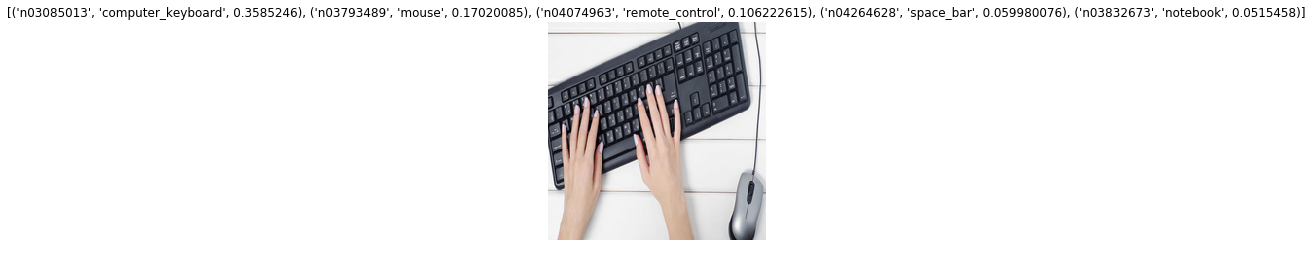

<Figure size 432x288 with 0 Axes>

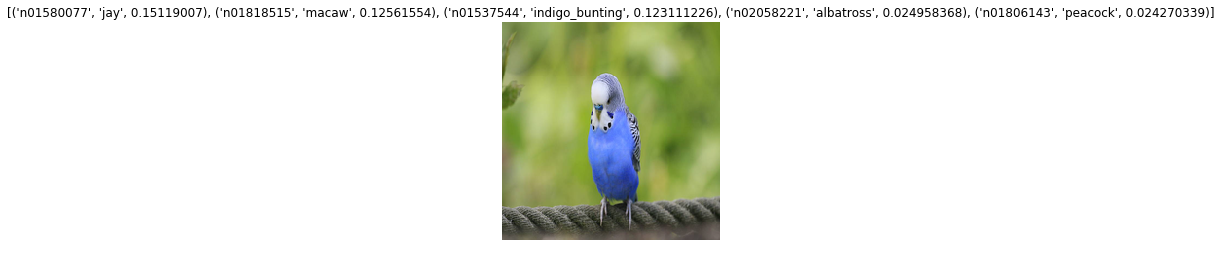

<Figure size 432x288 with 0 Axes>

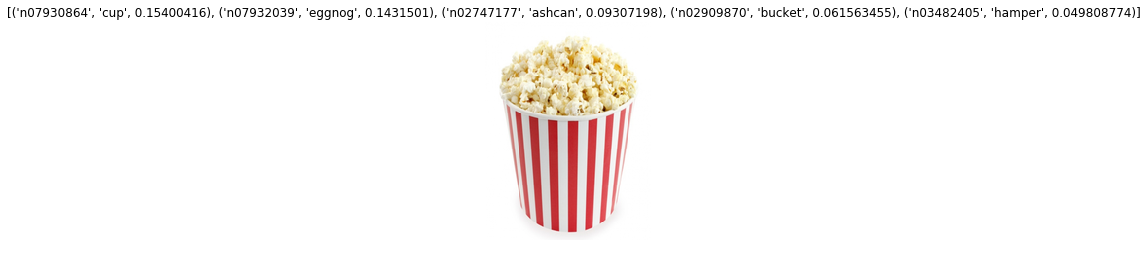

<Figure size 432x288 with 0 Axes>

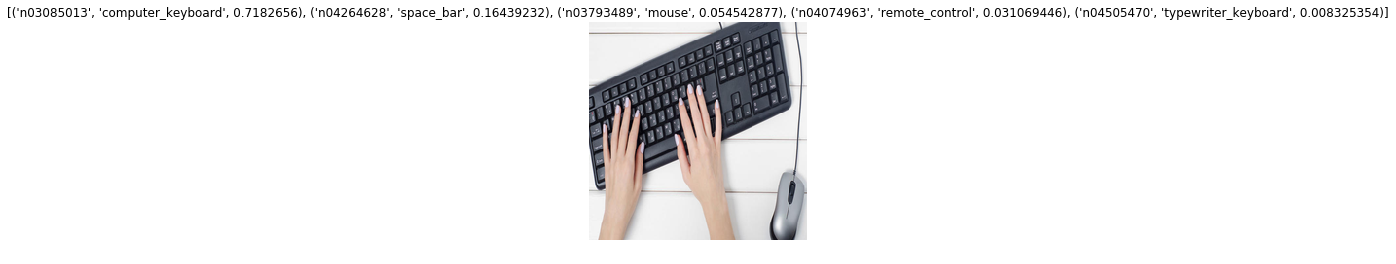

<Figure size 432x288 with 0 Axes>

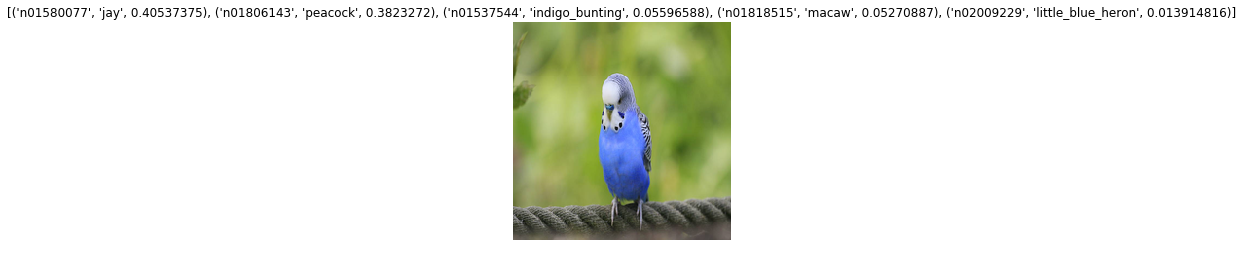

<Figure size 432x288 with 0 Axes>

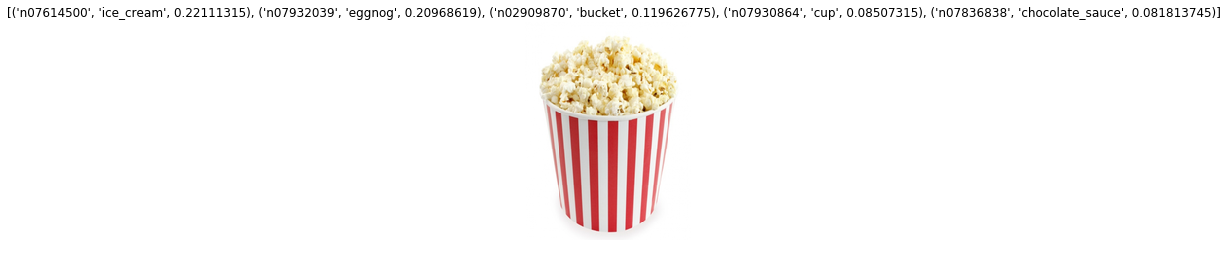

<Figure size 432x288 with 0 Axes>

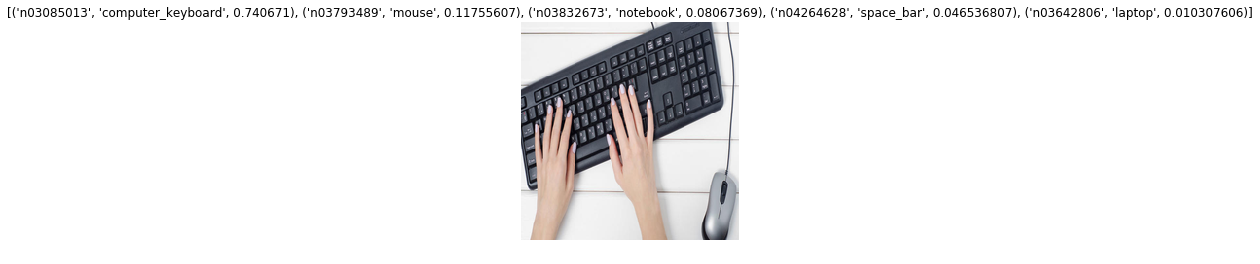

<Figure size 432x288 with 0 Axes>

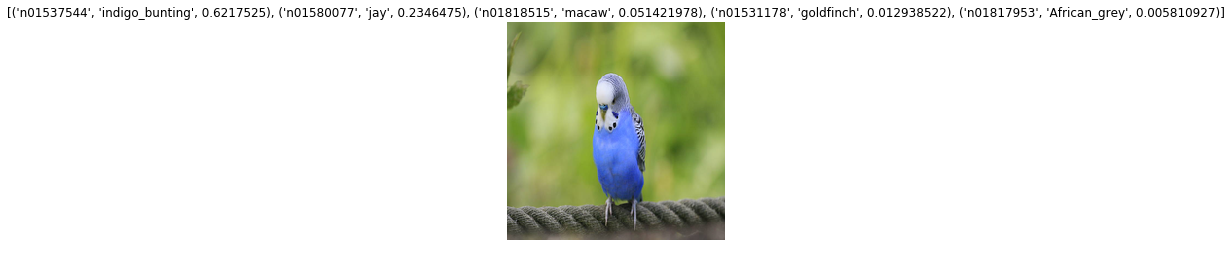

<Figure size 432x288 with 0 Axes>

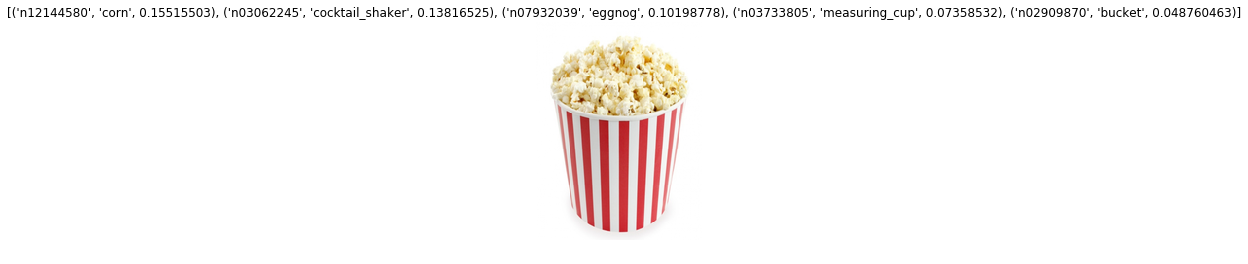

<Figure size 432x288 with 0 Axes>

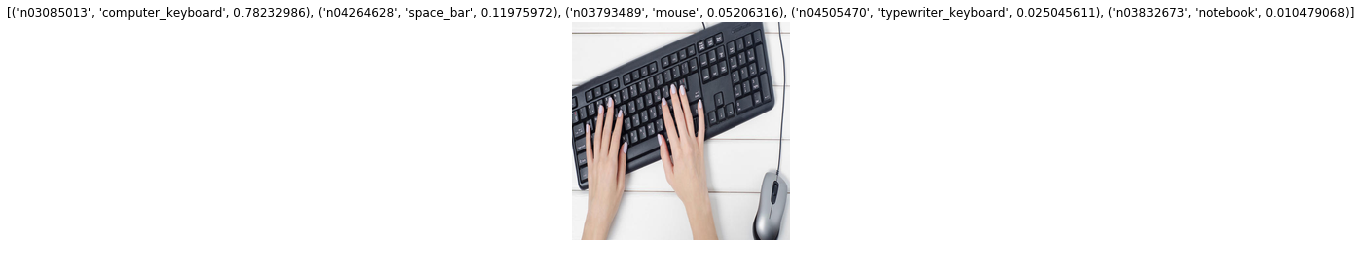

<Figure size 432x288 with 0 Axes>

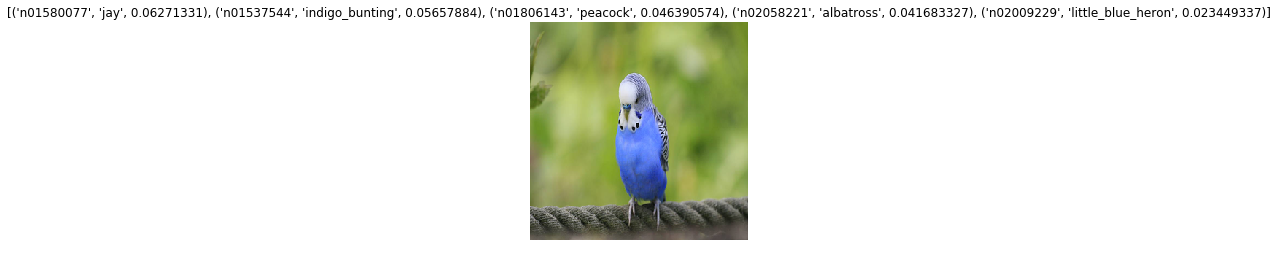

<Figure size 432x288 with 0 Axes>

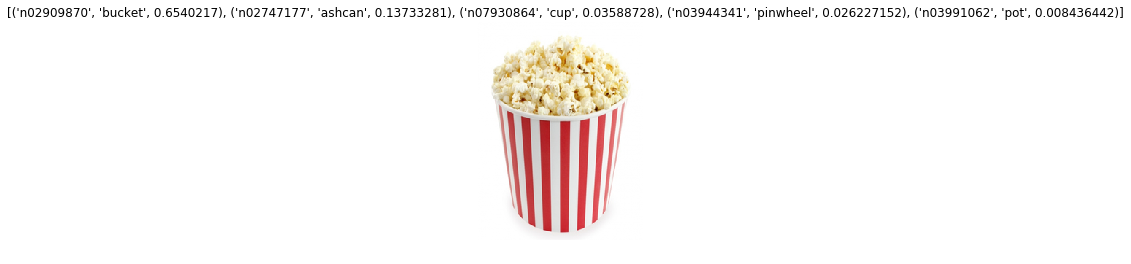

<Figure size 432x288 with 0 Axes>

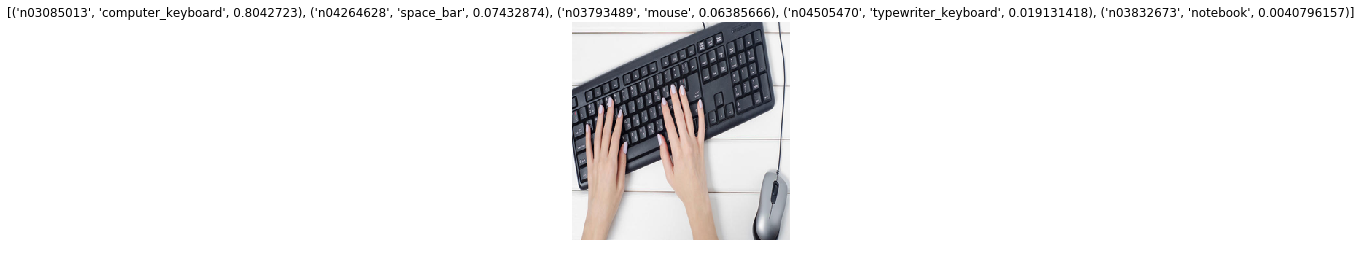

<Figure size 432x288 with 0 Axes>

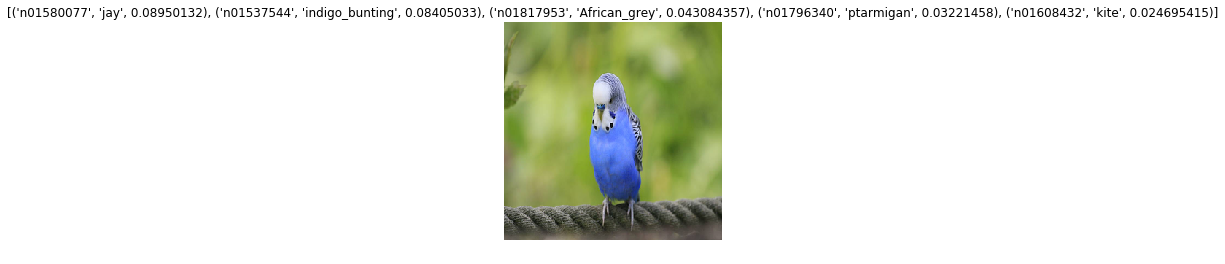

<Figure size 432x288 with 0 Axes>

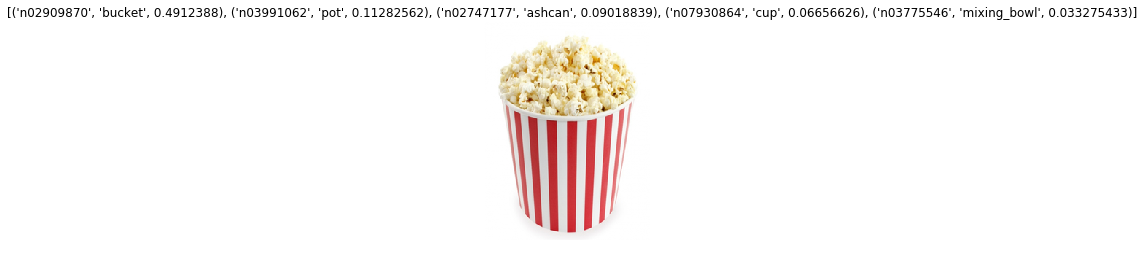

<Figure size 432x288 with 0 Axes>

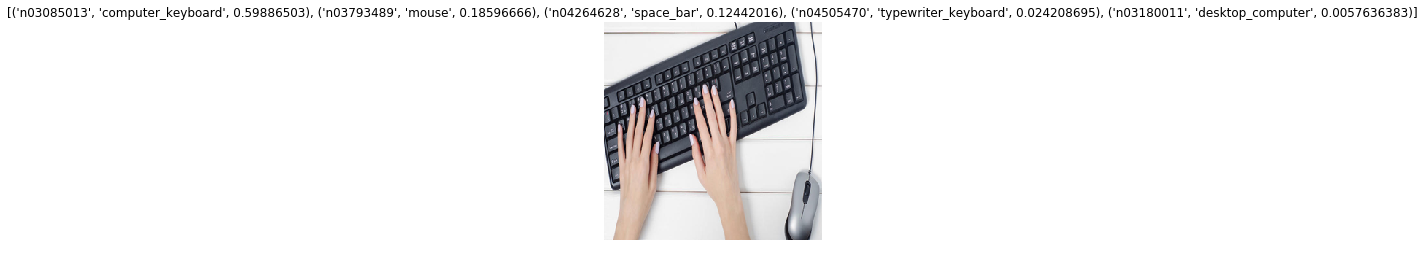

<Figure size 432x288 with 0 Axes>

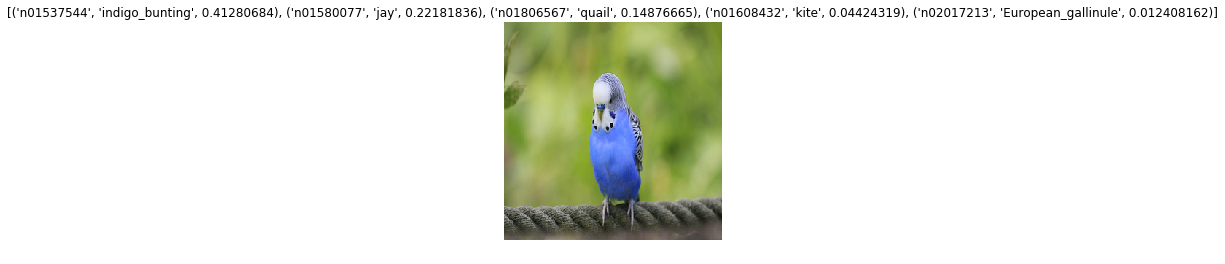

<Figure size 432x288 with 0 Axes>

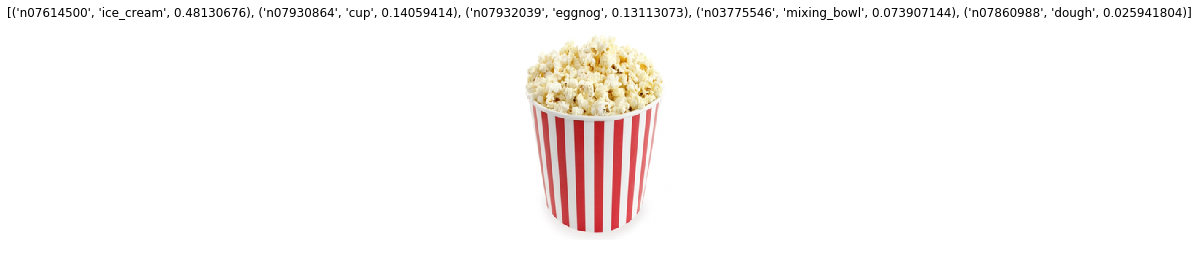

<Figure size 432x288 with 0 Axes>

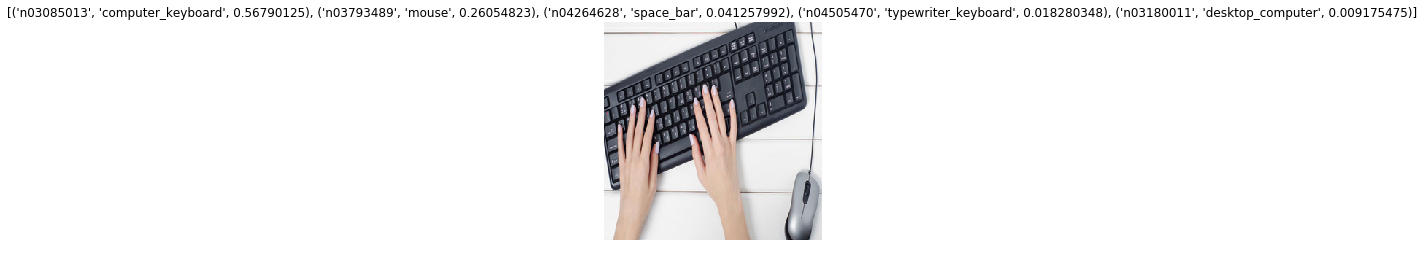

<Figure size 432x288 with 0 Axes>

In [91]:
# Optional: Print the images with the predicted classes
printClassificationResults(preparedImages224x224, predictedClassesVGG16)
printClassificationResults(preparedImages224x224, predictedClassesVGG19)
printClassificationResults(preparedImages224x224, predictedClassesMobileNetV2)
printClassificationResults(preparedImages224x224, predictedClassesResNet50)
printClassificationResults(preparedImages224x224, predictedClassesDenseNet201)
printClassificationResults(preparedImages299x299, predictedClassesInceptionV3)
printClassificationResults(preparedImages299x299, predictedClassesXception)
printClassificationResults(preparedImages299x299, predictedClassesInceptionResNet)

In [92]:
resultsList = [predictedClassesVGG16, predictedClassesVGG19, predictedClassesMobileNetV2, predictedClassesResNet50, predictedClassesDenseNet201, predictedClassesInceptionV3, predictedClassesXception, predictedClassesInceptionResNet]
modelList = ['VGG16', 'VGG19', 'MobileNetV2', 'ResNet50', 'DenseNet201', 'InceptionV3', 'Xception', 'InceptionResNet']

# Diese compareResults Methode braucht 4 Parameter:
# 1. Die Liste der Dateinamen
# 2. Die Ergebnisse der einzelnen Modellen, als Array zusammengefasst
# 3. Die Namen der Modelle, einfach als String Array
# 4. Threshold (mind. Sicherheit der Modellvorhersage) => nach Treffen am 17.04. auf 0.0 gesetzt (= kein Filter)
compareResults(foundFiles, resultsList, modelList, 0.00)

Comparing the Results for File: /tmp/image_classification/0/00/Bird.jpg
 >  1 . Platz @  VGG16  :  ('n01818515', 'macaw', 0.68094575)
 >  1 . Platz @  VGG19  :  ('n01537544', 'indigo_bunting', 0.62846345)
 >  1 . Platz @  MobileNetV2  :  ('n01580077', 'jay', 0.15119007)
 >  1 . Platz @  ResNet50  :  ('n01580077', 'jay', 0.40537375)
 >  1 . Platz @  DenseNet201  :  ('n01537544', 'indigo_bunting', 0.6217525)
 >  1 . Platz @  InceptionV3  :  ('n01580077', 'jay', 0.06271331)
 >  1 . Platz @  Xception  :  ('n01580077', 'jay', 0.08950132)
 >  1 . Platz @  InceptionResNet  :  ('n01537544', 'indigo_bunting', 0.41280684)
 >  2 . Platz @  VGG16  :  ('n01806143', 'peacock', 0.14961304)
 >  2 . Platz @  VGG19  :  ('n01580077', 'jay', 0.31593624)
 >  2 . Platz @  MobileNetV2  :  ('n01818515', 'macaw', 0.12561554)
 >  2 . Platz @  ResNet50  :  ('n01806143', 'peacock', 0.3823272)
 >  2 . Platz @  DenseNet201  :  ('n01580077', 'jay', 0.2346475)
 >  2 . Platz @  InceptionV3  :  ('n01537544', 'indigo_bu

In [93]:
allResultsCsv = generateCsvForModelComparison(foundFiles, resultsList, modelList)

for result in allResultsCsv:
  print(result)

VGG16;Bird.jpg;Popcorn.png;Keyboard.jpg
1.Platz;macaw;bucket;spatula
2.Platz;peacock;ashcan;remote_control
3.Platz;jay;pencil_sharpener;mouse
4.Platz;African_grey;cocktail_shaker;computer_keyboard
5.Platz;indigo_bunting;pill_bottle;space_bar

VGG19;Bird.jpg;Popcorn.png;Keyboard.jpg
1.Platz;indigo_bunting;bucket;computer_keyboard
2.Platz;jay;cup;mouse
3.Platz;peacock;coffee_mug;remote_control
4.Platz;macaw;ice_cream;space_bar
5.Platz;quail;ashcan;notebook

MobileNetV2;Bird.jpg;Popcorn.png;Keyboard.jpg
1.Platz;jay;cup;computer_keyboard
2.Platz;macaw;eggnog;space_bar
3.Platz;indigo_bunting;ashcan;mouse
4.Platz;albatross;bucket;remote_control
5.Platz;peacock;hamper;typewriter_keyboard

ResNet50;Bird.jpg;Popcorn.png;Keyboard.jpg
1.Platz;jay;ice_cream;computer_keyboard
2.Platz;peacock;eggnog;mouse
3.Platz;indigo_bunting;bucket;notebook
4.Platz;macaw;cup;space_bar
5.Platz;little_blue_heron;chocolate_sauce;laptop

DenseNet201;Bird.jpg;Popcorn.png;Keyboard.jpg
1.Platz;indigo_bunting;corn;comput

In [94]:
storeResultsToDB(foundFiles, resultsList, modelList)

==== other model =====
==== other file =====
241  |  /tmp/image_classification/0/00/Bird.jpg  |  VGG16  |  macaw  |  0.68094575
242  |  /tmp/image_classification/0/00/Bird.jpg  |  VGG16  |  peacock  |  0.14961304
243  |  /tmp/image_classification/0/00/Bird.jpg  |  VGG16  |  jay  |  0.042903136
244  |  /tmp/image_classification/0/00/Bird.jpg  |  VGG16  |  African_grey  |  0.035034887
245  |  /tmp/image_classification/0/00/Bird.jpg  |  VGG16  |  indigo_bunting  |  0.028494628
==== other file =====
246  |  /tmp/image_classification/0/06/Popcorn.png  |  VGG16  |  bucket  |  0.35633236
247  |  /tmp/image_classification/0/06/Popcorn.png  |  VGG16  |  ashcan  |  0.11119151
248  |  /tmp/image_classification/0/06/Popcorn.png  |  VGG16  |  pencil_sharpener  |  0.08659901
249  |  /tmp/image_classification/0/06/Popcorn.png  |  VGG16  |  cocktail_shaker  |  0.035657797
250  |  /tmp/image_classification/0/06/Popcorn.png  |  VGG16  |  pill_bottle  |  0.030174855
==== other file =====
251  |  /tmp/ima

In [101]:
querySearchWord("bucket")

Found following files for your search word "bucket":
0
0


IndexError: ignored

<Figure size 432x288 with 0 Axes>